## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

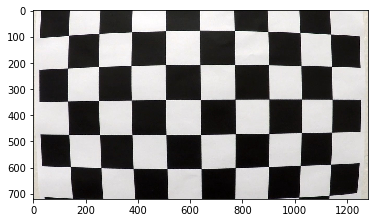

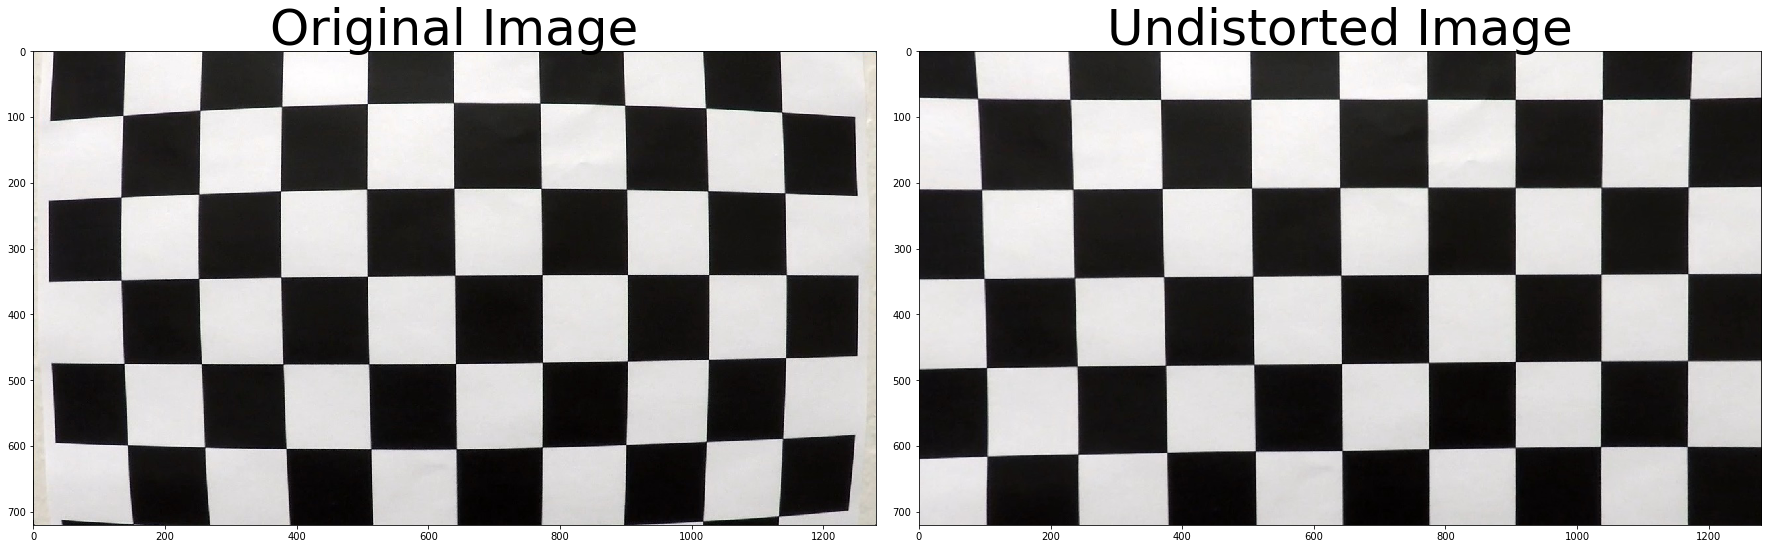

In [12]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#%matplotlib qt
#%matplotlib inline

image = mpimg.imread('../camera_cal/calibration1.jpg')
image_shape = image.shape
plt.imshow(image)

# A function that takes an image, object points, and image points
# performs the camera calibration, image distortion correction and 
# returns the undistorted image
def cal_undistort(img, objpoints, imgpoints):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, image_shape[:2], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

# prepare object points
nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')
# images = glob.glob('../camera_cal/calibration1.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
    
# Draw and display the corners
# img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
# cv2.imshow('img',img)
# cv2.waitKey(500)
undistorted = cal_undistort(image, objpoints, imgpoints)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        
# mpimg.imsave('../output_images/calibration1_output.jpg', undistorted)
f.savefig('../output_images/chessboard_fix.jpg')

# cv2.destroyAllWindows()

## And so on and so forth...

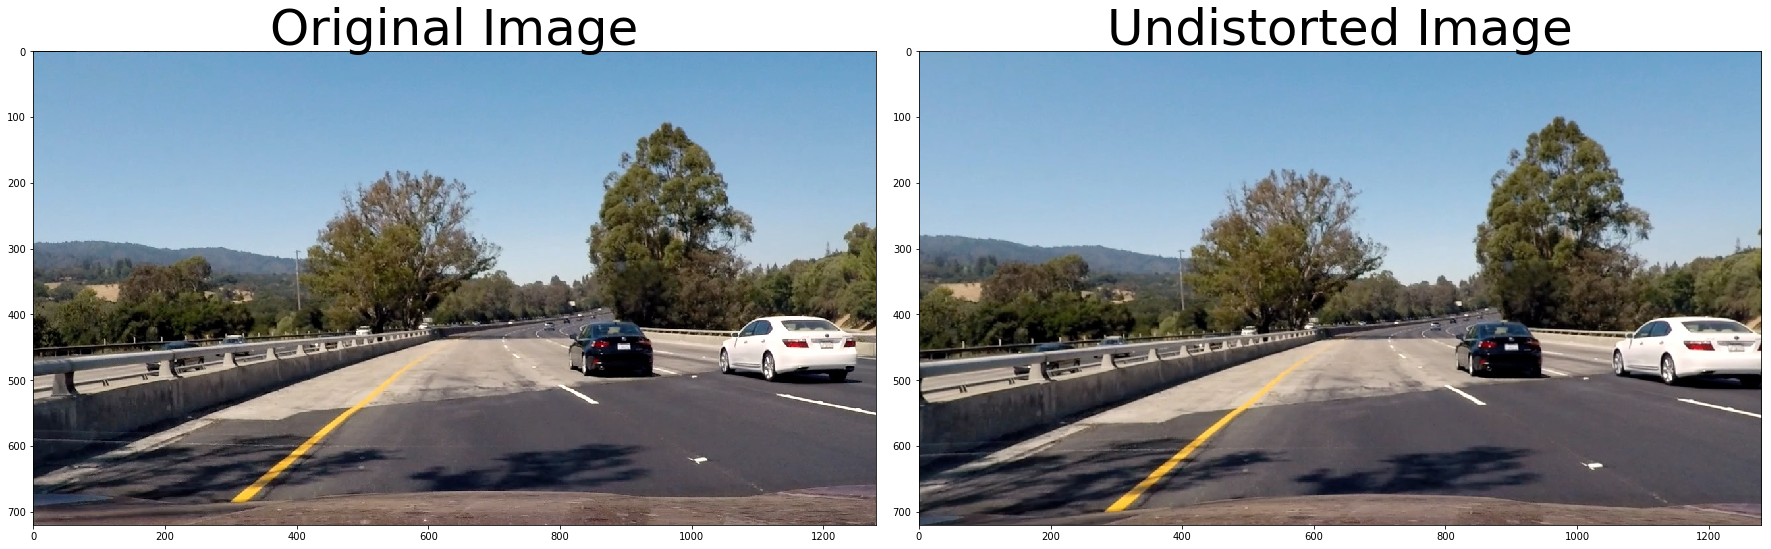

In [13]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Make a list of calibration images
images = glob.glob('../test_images/test4.jpg')
# images = glob.glob('../test_images/straight_lines1.jpg')
# Step through the list and search for chessboard corners
for fname in images:
    # img = cv2.imread(fname)
    img = mpimg.imread(fname)

    undistorted = cal_undistort(img, objpoints, imgpoints)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(undistorted)
    ax2.set_title('Undistorted Image', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        
    mpimg.imsave('../output_images/calibration_test4.jpg', undistorted)
    # mpimg.imsave('../output_images/calibration_straight_lines1.jpg', undistorted)

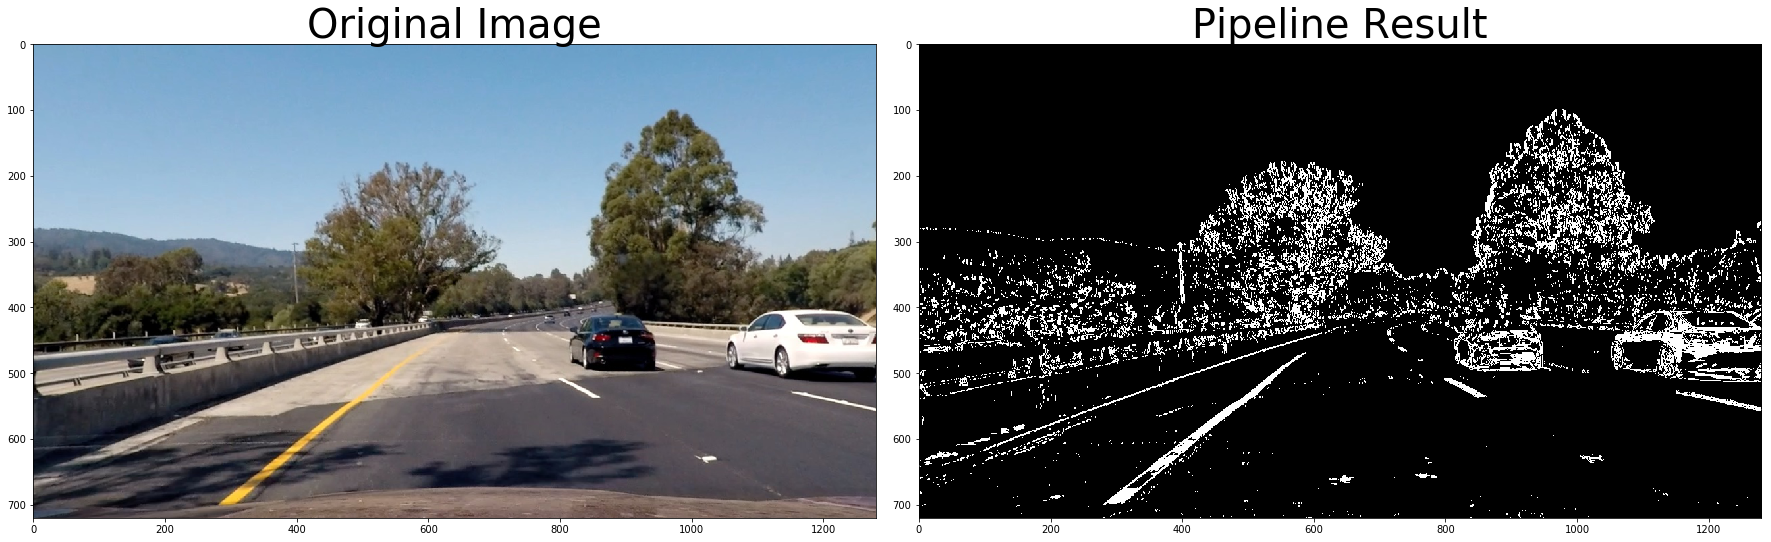

In [14]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


image = mpimg.imread('../output_images/calibration_test4.jpg')

# Edit this function to create your own pipeline.
def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    # Combine the two binary thresholds
    color_binary = np.zeros_like(sxbinary)
    color_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return color_binary
    
result = pipeline(image)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image, cmap='gray')
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result, cmap='gray')
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

mpimg.imsave('../output_images/binary_test4.jpg', result)

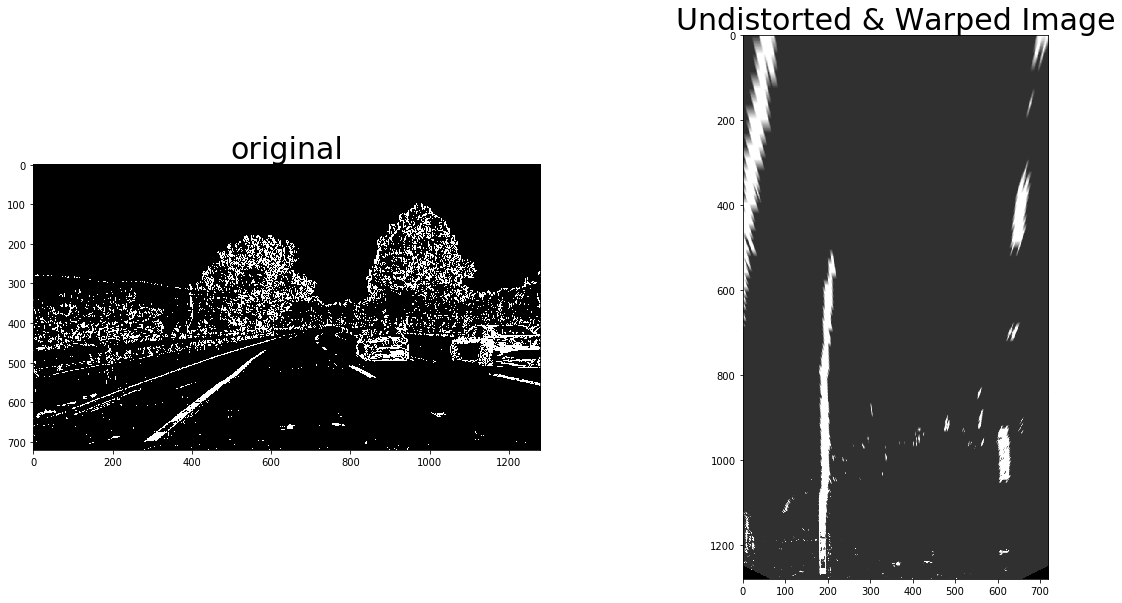

In [15]:
def compute_warp_points(image_height,image_width,x_adjustment=0):
    
    # calculator the vertices inside the region of interest
    x_center=image_width/2+x_adjustment
    x_offset=120
    x_window=54
    y_offset=450
    
    
    src_points = np.float32(
        [(x_offset,image_height),
         (x_center-x_window, y_offset), 
         (x_center+x_window,y_offset), 
         (image_width-x_offset,image_height)])
    
    dst_points = np.float32(
        [(x_offset,image_width),
         (x_offset,0),
         (image_height-x_offset, 0),
        (image_height-x_offset,image_width)])
        
    return src_points, dst_points

def perspective_transforms_matrix(src_points, dst_points):
    M_forward = cv2.getPerspectiveTransform(src_points, dst_points)
    M_backward = cv2.getPerspectiveTransform(dst_points, src_points)
    
    return M_forward, M_backward

def perspective_warp(img, Matrix):
    img_size = (img.shape[0], img.shape[1])
    
    warped = cv2.warpPerspective(img, Matrix, img_size, flags=cv2.INTER_LINEAR)
    
    return warped

import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Make a list of calibration images
images = glob.glob('../output_images/binary_test4.jpg')

for fname in images:
    img = mpimg.imread(fname)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    src, dst = compute_warp_points(img.shape[0],img.shape[1])
    M_forward, M_backward = perspective_transforms_matrix(src, dst)
    # draw_lines(undistorted,src)
    
    warped = perspective_warp(img, M_forward)
    
    # Visualize undistortion
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img, cmap='gray')
    ax1.set_title("original", fontsize=30)
    ax2.imshow(warped, cmap='gray')
    ax2.set_title('Undistorted & Warped Image', fontsize=30)

    mpimg.imsave('../output_images/warped_test4.jpg', warped)

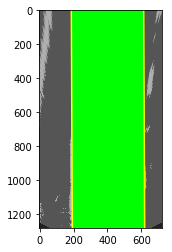

In [16]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2

# Load our image
binary_warped = mpimg.imread('../output_images/warped_test4.jpg')
binary_warped = cv2.cvtColor(binary_warped,cv2.COLOR_BGR2GRAY)

def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    # nwindows = 9
    nwindows = 6
    # Set the width of the windows +/- margin
    # margin = 100
    margin = 50
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin  # Update this
        win_xleft_high = leftx_current + margin  # Update this
        win_xright_low = rightx_current - margin  # Update this
        win_xright_high = rightx_current + margin  # Update this
        
        # Draw the windows on the visualization image
        # cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        # (win_xleft_high,win_y_high),(0,255,0), 2) 
        # cv2.rectangle(out_img,(win_xright_low,win_y_low),
        # win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        # pass # Remove this when you add your function

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img
    
def fit_polynomial(binary_warped, ym_per_pix=30/720, xm_per_pix=3.7/700):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    # left_fit = None
    # right_fit = None
    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)

    ## Visualization ##
    # Colors in the left and right lane regions
    # out_img[lefty, leftx] = [255, 0, 0]
    # out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    left_line_window = np.array(np.transpose(np.vstack([left_fitx, ploty])))
    right_line_window = np.array(np.flipud(np.transpose(np.vstack([right_fitx, ploty]))))
    line_points = np.vstack((left_line_window, right_line_window))
    cv2.fillPoly(out_img, np.int_([line_points]), [0,255, 0])

    return out_img, ploty, left_fit_cr, right_fit_cr, left_fitx, right_fitx


out_img, ploty, left_fit_cr, right_fit_cr, left_fitx, right_fitx = fit_polynomial(binary_warped)

plt.imshow(out_img)
mpimg.imsave('../output_images/lined_test4.jpg', out_img)

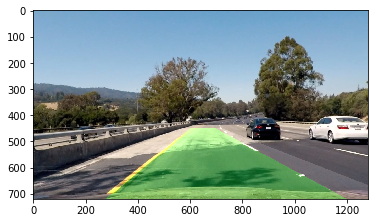

In [17]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2

# Load our image
color_warp = mpimg.imread('../output_images/lined_test4.jpg')
undistorted_image = mpimg.imread('../output_images/calibration_test4.jpg')
                                 
# binary_warped = cv2.cvtColor(binary_warped,cv2.COLOR_BGR2GRAY)

def perspective_unwarp(img, Minv):
    #img_size = (img.shape[1], img.shape[0])
    img_size = (img.shape[0], img.shape[1])
    
    unwarped = cv2.warpPerspective(img, M_backward, img_size, flags=cv2.INTER_LINEAR)
    
    return unwarped

newwarp = perspective_unwarp(color_warp, M_backward) 
result = cv2.addWeighted(undistorted_image, 1, newwarp, 0.3, 0)
plt.imshow(result)
mpimg.imsave('../output_images/result_test4.jpg', result)

In [18]:
warped = mpimg.imread('../output_images/lined_test4.jpg')

num_rows = warped.shape[0]

def measure_curvature_real(ploty, left_fit_cr, right_fit_cr):
    ym_per_pix = 30/1280 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    y_eval = np.max(ploty)
    
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
  
    return left_curverad, right_curverad

In [19]:
left_curverad, right_curverad = measure_curvature_real(ploty, left_fit_cr, right_fit_cr)
print(left_curverad)
print(right_curverad)

9.2523675763e+16
4.44218784203e+16


In [20]:
    # compute the offset from the center
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    lane_center = (right_fitx[0] + left_fitx[0])/2
    center_offset_pixels = abs(warped.shape[0]/2 - lane_center)
    center_offset_mtrs = xm_per_pix*center_offset_pixels
    offset_string = "Center offset: %.2f m" % center_offset_mtrs
    curvature_string = "Curvature: %.2f m" % left_curverad
    print(offset_string)

Center offset: 1.27 m


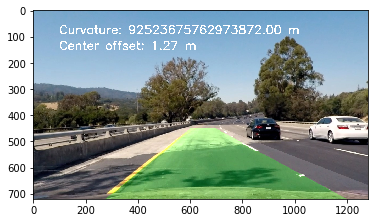

In [21]:
    cv2.putText(result,curvature_string , (100, 90), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,0,255), thickness=3)
    cv2.putText(result, offset_string, (100, 150), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,0,255), thickness=3)
    plt.imshow(result)

In [22]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def plot_images(image1, image2, output_file=None, gray=False):
    '''
    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()

    if gray:
        ax1.imshow(image1, cmap='gray')
    else:
        ax1.imshow(image1)
    ax1.set_title('Original Image', fontsize=40)

    if gray:
        ax2.imshow(image2, cmap='gray')
    else:
        ax2.imshow(image2)
    ax2.set_title('Result', fontsize=40)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    if output_file is not None:
        f.savefig(output_file)
    '''
    pass
        
image = mpimg.imread('../camera_cal/calibration1.jpg')
image_shape = image.shape
# plt.imshow(image)

def compute_undistort():
    ''' 
    compute mtx, dist matrix to calibrate camera
    '''
    # prepare object points
    nx = 9 # the number of inside corners in x
    ny = 5 # the number of inside corners in y

    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    
    # Make a list of calibration images
    images = glob.glob('../camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, image_shape[::2], None, None)      
    return mtx, dist

def undistort_image(image, mtx, dist, output_file='../output_images/undistorted_image.jpg'):   
    undistorted = cv2.undistort(image, mtx, dist, None, mtx)
    # print out image for debugging
    plot_images(image, undistorted, output_file)
    return undistorted

def color_gradient_image(imgage, s_thresh=(170, 255), sx_thresh=(20, 100)):
    # img = np.copy(imgage)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(imgage, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    # Combine the two binary thresholds
    threshold_binary = np.zeros_like(sxbinary)
    threshold_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    # print out image for debugging
    plot_images(image, threshold_binary, '../output_images/thresholded_image.jpg', True)
    return threshold_binary

def compute_warp_points(image_height,image_width,x_adjustment=0):  
    # calculator the vertices inside the region of interest
    x_center=image_width/2+x_adjustment
    x_offset=120
    x_window=54
    y_offset=450 
    src_points = np.float32(
        [(x_offset,image_height),
         (x_center-x_window, y_offset), 
         (x_center+x_window,y_offset), 
         (image_width-x_offset,image_height)])   
    dst_points = np.float32(
        [(x_offset,image_width),
         (x_offset,0),
         (image_height-x_offset, 0),
        (image_height-x_offset,image_width)])       
    return src_points, dst_points

def perspective_transforms_matrix(src_points, dst_points):
    M_forward = cv2.getPerspectiveTransform(src_points, dst_points)
    M_backward = cv2.getPerspectiveTransform(dst_points, src_points)  
    return M_forward, M_backward

def perspective_warp(img, Matrix):
    img_size = (img.shape[0], img.shape[1])  
    warped = cv2.warpPerspective(img, Matrix, img_size, flags=cv2.INTER_LINEAR)  
    return warped


def perspective_warped_binary(image):
    # image = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    src, dst = compute_warp_points(image.shape[0],image.shape[1])
    M_forward, M_backward = perspective_transforms_matrix(src, dst)
    perspective_warped = perspective_warp(image, M_forward)
    plot_images(image, perspective_warped, '../output_images/perspective_warped_image.jpg', True)
    return perspective_warped, M_backward
    
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    # nwindows = 9
    nwindows = 6
    # Set the width of the windows +/- margin
    # margin = 100
    margin = 50
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin  # Update this
        win_xleft_high = leftx_current + margin  # Update this
        win_xright_low = rightx_current - margin  # Update this
        win_xright_high = rightx_current + margin  # Update this
        
        # Draw the windows on the visualization image
        # cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        # (win_xleft_high,win_y_high),(0,255,0), 2) 
        # cv2.rectangle(out_img,(win_xright_low,win_y_low),
        # win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img
    
def fit_polynomial(binary_warped, ym_per_pix=30/720, xm_per_pix=3.7/700):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)

    ## Visualization ##
    # Colors in the left and right lane regions
    # out_img[lefty, leftx] = [255, 0, 0]
    # out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    left_line_window = np.array(np.transpose(np.vstack([left_fitx, ploty])))
    right_line_window = np.array(np.flipud(np.transpose(np.vstack([right_fitx, ploty]))))
    line_points = np.vstack((left_line_window, right_line_window))
    cv2.fillPoly(out_img, np.int_([line_points]), [0,255, 0])
    plot_images(binary_warped, out_img, '../output_images/line_image.jpg')    
    return out_img, ploty, left_fit_cr, right_fit_cr, left_fitx, right_fitx

def perspective_unwarp(img, M_backward):
    img_size = (img.shape[0], img.shape[1])    
    unwarped = cv2.warpPerspective(img, M_backward, img_size, flags=cv2.INTER_LINEAR)  
    return unwarped

def measure_curvature_real(ploty, left_fit_cr, right_fit_cr):
    #ym_per_pix = 30/720 # meters per pixel in y dimension
    #xm_per_pix = 3.7/700 # meters per pixel in x dimension
    ym_per_pix = 30/1280 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    y_eval = np.max(ploty)    
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])    
    return left_curverad, right_curverad

def AddOffsetCurverad(image, ploty, left_fit_cr, right_fit_cr, right_fitx, left_fitx):
    # compute curveratur
    left_curverad, right_curverad = measure_curvature_real(ploty, left_fit_cr, right_fit_cr)

    # compute the offset from the center
    # xm_per_pix = 3.7/700 # meters per pixel in x dimension
    xm_per_pix = 3.7/700
    lane_center = (right_fitx[0] + left_fitx[0])/2
    center_offset_pixels = abs(image.shape[0]/2 - lane_center)
    center_offset_mtrs = xm_per_pix*center_offset_pixels
    offset_string = "Center offset: %.2f m" % center_offset_mtrs
    left_curvature_string = "Left Curvature: %.2f m" % left_curverad
    right_curvature_string = "Right Curvature: %.2f m" % right_curverad
    average_curerad = (left_curverad + right_curverad)/4
    curvature_string = "Curvature: %.2f m" % average_curerad
    # print(offset_string)
    # print(left_curvature_string)
    # print(right_curvature_string)
    #cv2.putText(image,left_curvature_string , (100, 90), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,0,255), thickness=3)
    #cv2.putText(image,right_curvature_string , (100, 150), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,0,255), thickness=3)
    cv2.putText(image,curvature_string , (100, 150), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,0,255), thickness=3)
    cv2.putText(image, offset_string, (100, 200), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,0,255), thickness=3)
    
    return image

array([[[123, 167, 206],
        [123, 167, 206],
        [122, 166, 205],
        ..., 
        [112, 166, 204],
        [112, 166, 204],
        [112, 166, 204]],

       [[123, 167, 205],
        [123, 167, 205],
        [122, 166, 204],
        ..., 
        [112, 166, 204],
        [112, 166, 204],
        [112, 166, 204]],

       [[122, 166, 203],
        [122, 166, 203],
        [122, 166, 203],
        ..., 
        [112, 166, 204],
        [112, 166, 204],
        [112, 166, 204]],

       ..., 
       [[ 37,  34,  42],
        [ 37,  34,  43],
        [ 39,  35,  44],
        ..., 
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[ 42,  35,  45],
        [ 44,  37,  47],
        [ 46,  38,  49],
        ..., 
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[ 46,  36,  47],
        [ 48,  38,  49],
        [ 49,  39,  50],
        ..., 
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,

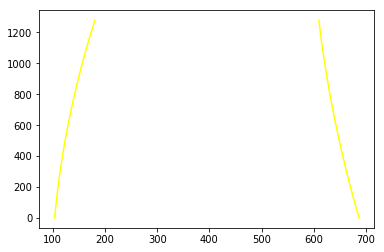

In [23]:
mtx, dist = compute_undistort()
def image_process_pipeline(image):
    # mtx, dist = compute_undistort()
    undistorted = undistort_image(image, mtx, dist)
    threshold_binary = color_gradient_image(undistorted)
    perspective_warped, M_backward = perspective_warped_binary(threshold_binary)
    color_warp, ploty, left_fit_cr, right_fit_cr, left_fitx, right_fitx = fit_polynomial(perspective_warped, 30/1280, 3.7/525)
    warp_inverse = perspective_unwarp(color_warp, M_backward) 
    result = cv2.addWeighted(undistorted, 1, warp_inverse, 0.3, 0)
    plot_images(undistorted, result, '../output_images/final_image.jpg')
    result = AddOffsetCurverad(result, ploty, left_fit_cr, right_fit_cr, right_fitx, left_fitx)
    plot_images(undistorted, result, '../output_images/text_image.jpg')
    return result

def chessboard_image_process_pipeline(image):
    mtx, dist = compute_undistort()
    undistorted = undistort_image(image, mtx, dist, '../output_images/undistorted_chessboard_image.jpg')
    
image = mpimg.imread('../test_images/test4.jpg')
chessboard_image = mpimg.imread('../camera_cal/calibration1.jpg')

chessboard_image_process_pipeline(chessboard_image )
image_process_pipeline(image)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [05:20<00:00,  3.78it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 2min 56s, sys: 16 s, total: 3min 12s
Wall time: 5min 23s


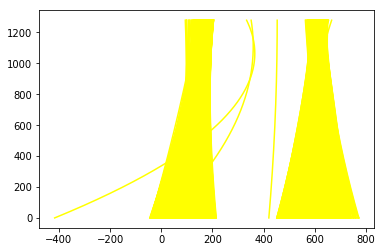

In [24]:
from moviepy.editor import VideoFileClip

output = 'project_video_output.mp4'
clip1 = VideoFileClip("../project_video.mp4")
white_clip = clip1.fl_image(image_process_pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)